In [77]:
# import libraries we'll need
import urllib
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Load SoS Data 

In [78]:
start_date = '20221207'
end_date = '20221226'
VARIABLES = [
    'SWE_p1_c',
    'SWE_p2_c',
    'SWE_p3_c',
    'SWE_p4_c',
    'T_2m_c',
    'spd_1m_ue',
    'spd_3m_ue',
    'spd_10m_ue',
    'SF_avg_1m_ue',
    'SF_avg_2m_ue'
]
download_directory = "/data2/elilouis/sublimationofsnow/sosnoqc/"

In [79]:
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = os.path.join('ftp://', base_url, path, file)
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

In [80]:
# Create a list of datetime objects for every day between the provided start_date and end_date. 
datelist = pd.date_range(
    dt.datetime.strptime(start_date, '%Y%m%d'),
    dt.datetime.strptime(end_date, '%Y%m%d'),
    freq='d'
).strftime('%Y%m%d').tolist()

# Download one daily file for each date in the datelist. 
# cache = True so that when we rerun the notebook in the future, we don't have to redownload the data.
files = [download_sos_data_day(date, download_directory, cache=True) for date in datelist]

Caching...skipping download for 20221207
Caching...skipping download for 20221208
Caching...skipping download for 20221209
Caching...skipping download for 20221210
Caching...skipping download for 20221211
Caching...skipping download for 20221212
Caching...skipping download for 20221213
Caching...skipping download for 20221214
Caching...skipping download for 20221215
Caching...skipping download for 20221216
Caching...skipping download for 20221217
Caching...skipping download for 20221218
Caching...skipping download for 20221219
Caching...skipping download for 20221220
Caching...skipping download for 20221221
Caching...skipping download for 20221222
Caching...skipping download for 20221223
Caching...skipping download for 20221224
Caching...skipping download for 20221225
Caching...skipping download for 20221226


In [81]:
# Open up datasets from every day, extracting our VARIABLES of choice as we open individual datasets. This is so that we have a smaller dataset held 
# in computer memory.
all_datasets = [xr.open_dataset(file)[VARIABLES] for file in files]

In [82]:
sos_dataset = xr.concat(all_datasets, dim='time')

In [83]:
sos_dataset_60min = sos_dataset.resample(time="60Min").mean()

# Load SoS Lidar Data

In [84]:
# load data file (we will focus on lidar 6, others will be useful for the homework)
ds6 = xr.open_dataset('../modules/data/lidar_l6_pillow_depths.nc').sel(time=slice(sos_dataset_60min.time.min(), sos_dataset_60min.time.max()))

# Interpolate SoS data to match LIDAR data and calculate bulk snow densities

In [94]:
sos_dataset_60min_interpolated = sos_dataset_60min.interp_like(ds6)
density_uw = 100*sos_dataset_60min_interpolated['SWE_p1_c'] / (ds6.sel(pillow='UW', stat='median')['snowdepth']*1000)
density_c = 100*sos_dataset_60min_interpolated['SWE_p3_c'] / (ds6.sel(pillow='C', stat='median')['snowdepth']*1000)
density_d = 100*sos_dataset_60min_interpolated['SWE_p4_c'] / (ds6.sel(pillow='D', stat='median')['snowdepth']*1000)

# Problem 1: data analysis

Based on combining material in Labs 2 & 3 and Modules 2 & 3

In Lab 2 and Module 2, we saw that in late December, one of the four snow pillows had a sudden increase in snow water equivalent while the other three had a decrease. In Lab 3, we saw a similar pattern in the snow depth measurements near of the snow pillows. Look at the snow depths, the snow densities, wind speeds, and snow particle fluxes during this period. Create plots to help explain what is happening here. Referencing your plots, explain what happened in Kettle Ponds during this period. You may also want to check out the weekly weather blog.

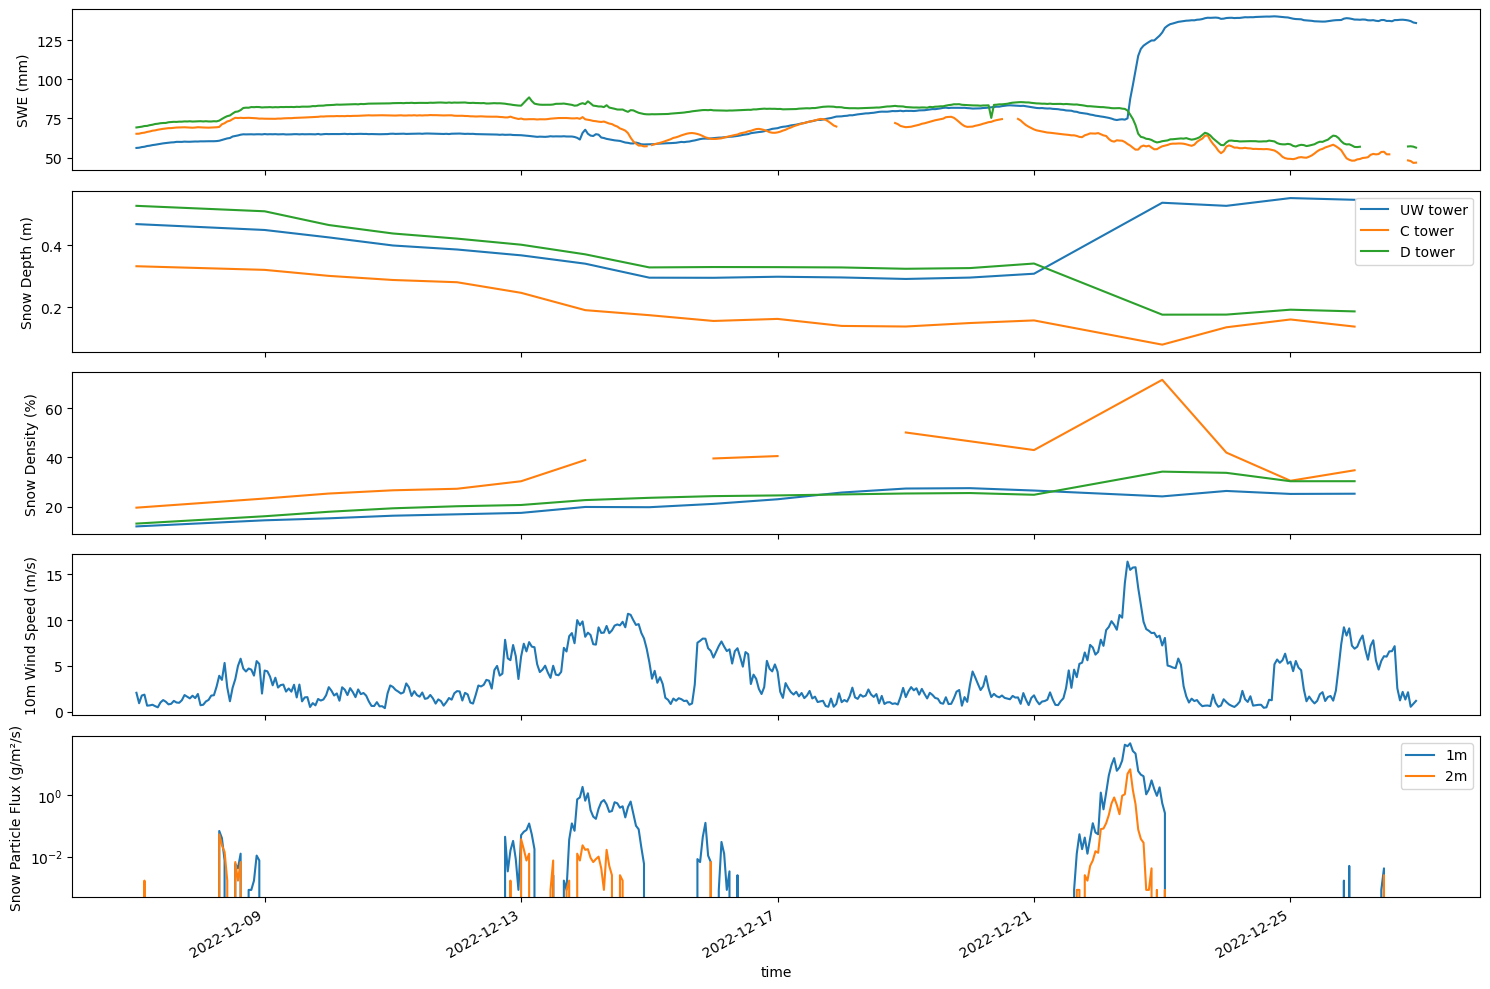

In [98]:
# Snow depth data - LIDAR data
# Snow densities - LIDAR data and Snow Pillow data
# Wind Speeds - Anemometer data
# Snow particle fluxes - FlowCapt data

fig, axes = plt.subplots(5,1, figsize=(15,10), sharex=True)

sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='UW tower')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='C tower')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='D tower')

ds6.sel(stat='median', pillow='UW')['snowdepth'].plot(ax=axes[1], label='UW tower')
ds6.sel(stat='median', pillow='C')['snowdepth'].plot(ax=axes[1], label='C tower')
ds6.sel(stat='median', pillow='D')['snowdepth'].plot(ax=axes[1], label='D tower')

density_uw.plot(ax=axes[2], label='UW tower')
density_c.plot(ax=axes[2], label='C tower')
density_d.plot(ax=axes[2], label='D tower')
axes[1].legend()

sos_dataset_60min['spd_10m_ue'].plot(ax=axes[3])

sos_dataset_60min['SF_avg_1m_ue'].plot(ax=axes[4], label='1m')
sos_dataset_60min['SF_avg_2m_ue'].plot(ax=axes[4], label='2m')
axes[4].set_yscale('log')
axes[4].legend()

for ax in axes[:-1]:
    ax.set_xlabel('')
    ax.set_title('')

axes[0].set_ylabel("SWE (mm)")
axes[1].set_ylabel("Snow Depth (m)")
axes[2].set_ylabel("Snow Density (%)")
axes[3].set_ylabel("10m Wind Speed (m/s)")
axes[4].set_ylabel("Snow Particle Flux (g/m²/s)")

plt.tight_layout()
plt.show()

Examining SWE, snow depth and density, wind speed and snow particle flux, it seems that on December 21 there was a large wind event, associated with high synoptic wind speeds, that transported enough snow around the Kettle Ponds site to fill in a topographic depression at the UW tower and remove snow from flatter spots near the other towers. This is a case of "snow smooths landscapes" happening very quickly and having very dramatic effects on instruments that are distributed across a varied land surface.

# Problem 2: testing wind thresholds and particle counts

There is a threshold wind speed that must be exceeded for snow transport. Li and Pomeroy 1997 state that 10-m wind speeds must exceed about 7.7 m/s for dry snow transport and about 9.9 m/s for wet snow transport. Use the 10-m wind speed measurements and particle counters to test if these thresholds match the observations at Kettle Ponds. If you have time, further discuss the questions at the end of Lab 4-2.



We separate the data into two bins, time periods with wind speeds above 7.7m and below 7.7m. Then we look at the two distributions of snow particle flux measurements.

In [135]:
sos_df = sos_dataset.to_dataframe()

Text(0.5, 0.98, 'Relationship between snow particle flux and wind speed for both FlowCapt Sensors, colored by a wind threshold')

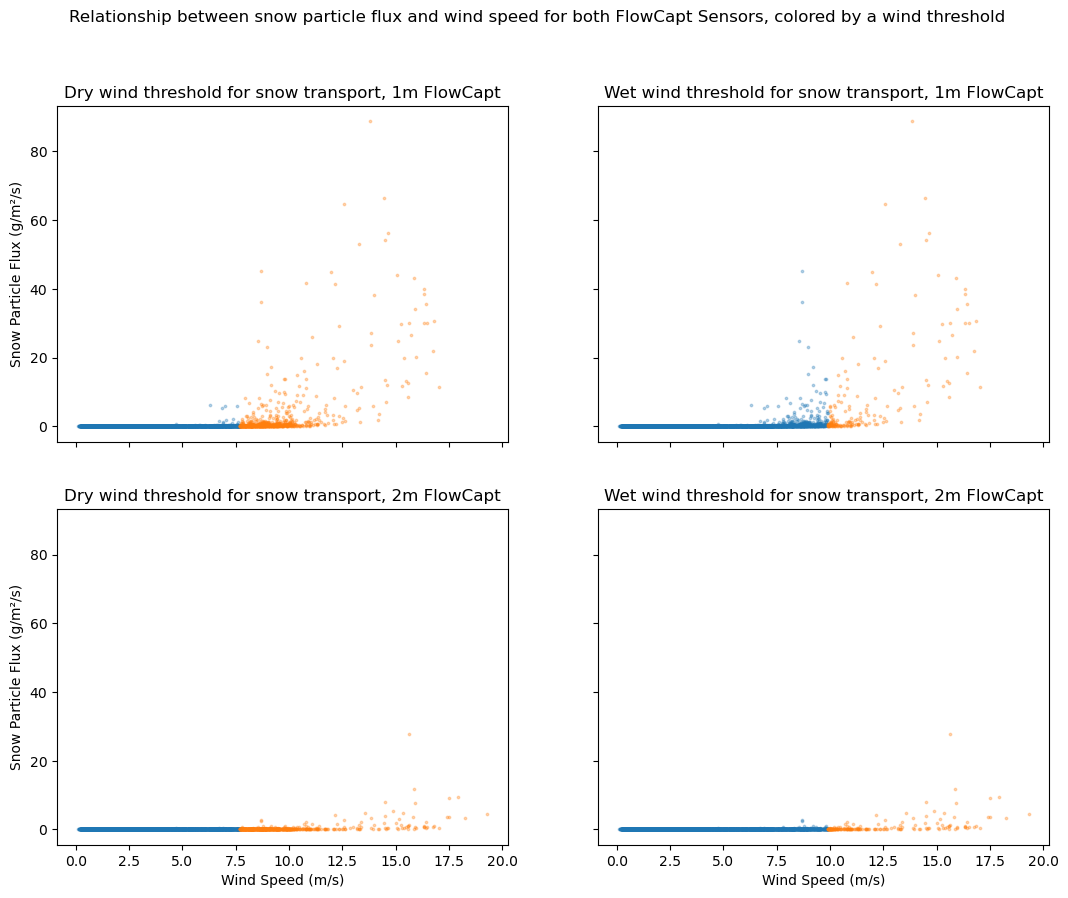

In [158]:
fig, axes = plt.subplots(2,2, figsize=(12.8, 4.8*2), sharex=True, sharey=True)

highdry = sos_df.query('spd_10m_ue >= 7.7')
lowdry = sos_df.query('spd_10m_ue < 7.7')

highwet = sos_df.query('spd_10m_ue >= 9.9')
lowwet = sos_df.query('spd_10m_ue < 9.9')

axes[0, 0].scatter(lowdry['spd_10m_ue'], lowdry['SF_avg_1m_ue'], s=3, alpha=0.3)
axes[0, 0].scatter(highdry['spd_10m_ue'], highdry['SF_avg_1m_ue'], s=3, alpha=0.3)
axes[0, 1].scatter(lowwet['spd_10m_ue'], lowwet['SF_avg_1m_ue'], s=3, alpha=0.3)
axes[0, 1].scatter(highwet['spd_10m_ue'], highwet['SF_avg_1m_ue'], s=3, alpha=0.3)

axes[1, 0].scatter(lowdry['spd_10m_ue'], lowdry['SF_avg_2m_ue'], s=3, alpha=0.3)
axes[1, 0].scatter(highdry['spd_10m_ue'], highdry['SF_avg_2m_ue'], s=3, alpha=0.3)
axes[1, 1].scatter(lowwet['spd_10m_ue'], lowwet['SF_avg_2m_ue'], s=3, alpha=0.3)
axes[1, 1].scatter(highwet['spd_10m_ue'], highwet['SF_avg_2m_ue'], s=3, alpha=0.3)

axes[1, 0].set_xlabel('Wind Speed (m/s)')
axes[1, 1].set_xlabel('Wind Speed (m/s)')
axes[0, 0].set_ylabel('Snow Particle Flux (g/m²/s)')
axes[1, 0].set_ylabel('Snow Particle Flux (g/m²/s)')

axes[0, 0].set_title('Dry wind threshold for snow transport, 1m FlowCapt')
axes[0, 1].set_title('Wet wind threshold for snow transport, 1m FlowCapt')
axes[1, 0].set_title('Dry wind threshold for snow transport, 2m FlowCapt')
axes[1, 1].set_title('Wet wind threshold for snow transport, 2m FlowCapt')

plt.suptitle("Relationship between snow particle flux and wind speed for both FlowCapt Sensors, colored by a wind threshold")

In [145]:
len(lowdry.query('SF_avg_1m_ue <= 0')), len(lowdry.query('SF_avg_1m_ue > 0')), len(highdry.query('SF_avg_1m_ue <= 0')), len(highdry.query('SF_avg_1m_ue > 0'))

(4732, 286)

In [159]:
len(lowwet.query('SF_avg_1m_ue <= 0')), len(lowwet.query('SF_avg_1m_ue > 0')), len(highwet.query('SF_avg_1m_ue <= 0')), len(highwet.query('SF_avg_1m_ue > 0'))

(4822, 733, 2, 173)

Examining data from the 1m Flow Capt sensor:
* Qualitatively, we see that the dry snow wind threshold of 7.7 m/s does a pretty good job of predicting blowing snow transport at Kettle Ponds. 
* There are very few data points with measured snow particules flux when wind speed is less than 7.7 m/s. 
* The wet snow wind threshold of 9.9 does a much worse job at discriminating between wind speeds associated with and without blowing snow.

Examining data from the 2m Flow Capt sensor:
* There is very little blowing snow at all.
* The dry and wet snow wind thresholds do a decent job predicting blowing snow, but the thresolds seem higher for snow blowing at the height of the 2m Flow Capt sensor.

# Problem 3: Project

Please give a brief update of where you are with your project. Let me know if you have any questions or concerns at this point.

No updates. I'm leaning towards the "I made some of the labs as my class project" options. I'm also still considering looking into the thermodynamics stuff, but if I presented anything it wouldn't be particularly detailed.